# Setup

In [63]:
import gc
import random

import astropy.units as u
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sunpy.map
import sunpy.visualization.colormaps.color_tables as ct
from astropy.visualization import AsinhStretch, ImageNormalize
from IPython.display import clear_output, display
from matplotlib.patches import Rectangle
from sunpy.coordinates import frames
from tqdm import tqdm
import json
import random
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

from contextlib import contextmanager

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
from Library.Processing import *
from Library.IO import *
from Library.Model import *
from Library.Metrics import *
from Library.Config import *
from Library.CH import *
from Library.Plot import *
from Models import load_date_range

In [66]:
pd.set_option("display.width", 10000)
pd.set_option("display.max_colwidth", None)

# Data Processing

In [67]:
df = pd.read_parquet(paths["artifact_root"] + "Paths.parquet")

In [68]:
ARCH_ID = "A2"
DATE_ID = "D2"

date_range = load_date_range(ARCH_ID, DATE_ID)
train_df, val_df = date_range.select_pairs(df)

In [69]:
# set-wise subtraction
if val_df is None:
    inf_df = df.loc[~df.index.isin(train_df.index)]
else:
    combined_df = pd.concat([train_df, val_df])
    inf_df = df.loc[~df.index.isin(combined_df.index)]

# Model

## Training

In [70]:
# train_model(train_df)

In [71]:
model = load_trained_model(ARCH_ID, DATE_ID)

/Users/aosh/Developer/helio-n/Outputs/Models/A2D2.keras


/opt/homebrew/Caskroom/miniconda/base/envs/icme3.12-metal/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


## Plotting

In [72]:
def plot_sdo(
    row,
    postprocessing="P0",
    oval=None,
    show_fits=True,
    pmap=None,
):
    """
    Double plotter wrapper around plot_ch_map().
    Keeps the original signature.

    - Left: U-Net (helio-n)
    - Right: IDL
    """
    print(row)
    # Keep existing diagnostic print; assumes these globals exist in your notebook/module
    params = (
        postprocessing
        if isinstance(postprocessing, dict)
        else get_postprocessing_params(postprocessing)
    )
    print_distance(row, model, params)

    # Keep old behavior: compute oval once and reuse
    if oval is None:
        oval = generate_omask(row)

    m = sunpy.map.Map(row.fits_path)

    # Map old "smoothing_params" to the string key plot_ch_map expects.
    # This preserves call compatibility without changing plot_ch_map's signature.
    # If you have a canonical mapping util, swap this block out.

    fig = plt.figure(figsize=((TARGET_PX / DPI) * 2.1, TARGET_PX / DPI))
    ax1 = fig.add_subplot(
        1, 2, 1, projection=m
    )  # let plot_ch_map create/use WCS projection internally
    ax2 = fig.add_subplot(1, 2, 2, projection=m)

    # Left panel: U-Net
    plot_ch_map(
        row,
        source="unet",
        model=model,  # required if no pmap_path/pmap on row
        pmap=pmap,  # plot_ch_map will load/compute if needed
        postprocessing=postprocessing,
        oval=oval,
        show_fits=show_fits,
        multiplot_ax=ax1,
        set_title=False,
    )
    ax1.set_title("helio-n (U-Net)")

    # Right panel: IDL
    plot_ch_map(
        row,
        source="idl",
        model=None,
        pmap=None,
        postprocessing=postprocessing,  # ignored for IDL, harmless to pass
        oval=oval,
        show_fits=show_fits,
        multiplot_ax=ax2,
        set_title=False,
    )
    ax2.set_title("IDL")

    plt.tight_layout()
    plt.show()

In [73]:
_SUPPRESS_REDRAW = 0


@contextmanager
def suppress_redraw():
    global _SUPPRESS_REDRAW
    _SUPPRESS_REDRAW += 1
    try:
        yield
    finally:
        _SUPPRESS_REDRAW -= 1


# -------------------------
# 0) Postprocessing presets
# -------------------------
PP_DIR = Path("./Config/Postprocessing").resolve()


def list_json_presets(pp_dir: Path):
    if not pp_dir.exists():
        return ["Custom"], {"Custom": None}

    files = sorted(
        [p for p in pp_dir.iterdir() if p.is_file() and p.suffix.lower() == ".json"]
    )
    names = [p.stem for p in files]
    mapping = {p.stem: p for p in files}

    # Ensure Custom exists as an option even if file missing
    if "Custom" not in mapping:
        names = ["Custom"] + names
        mapping["Custom"] = pp_dir / "Custom.json"

    # Make Custom default and first in list
    if "Custom" in names:
        names = ["Custom"] + [n for n in names if n != "Custom"]

    return names, mapping


PRESET_NAMES, PRESET_PATHS = list_json_presets(PP_DIR)
DEFAULT_PRESET = "P1" if "P1" in PRESET_NAMES else PRESET_NAMES[0]


def load_params_from_file(path: Path, fallback: dict):
    try:
        if path is None:
            return dict(fallback)
        with path.open("r", encoding="utf-8") as f:
            data = json.load(f)
        # Only take known keys; fallback for missing
        out = dict(fallback)
        for k in ["threshold", "closing_radius", "min_size", "hole_size"]:
            if k in data:
                out[k] = data[k]
        return out
    except Exception:
        return dict(fallback)


def write_params_to_custom(path: Path, params: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(params, f, indent=2, sort_keys=True)


# --------------------------------
# 1) Register your dataframes here
# --------------------------------
dfs = {
    "train": train_df,
    "inference": inf_df,
}

# ----------------
# 2) Widgets
# ----------------
full_row = widgets.Layout(width="100%")
row_wrap = widgets.Layout(
    display="flex", flex_flow="row wrap", align_items="center", width="100%"
)
checkbox_layout = widgets.Layout(margin="0 0 0 12px")


df_selector = widgets.RadioButtons(
    options=list(dfs.keys()),
    value="inference",
    description="DataFrame:",
    layout=widgets.Layout(margin="0 8px 0 0"),
)

idx_slider = widgets.IntSlider(
    value=random.randint(0, len(dfs["train"]) - 1) if len(dfs["train"]) else 0,
    min=0,
    max=max(0, len(dfs["train"]) - 1),
    step=1,
    description="Index:",
    continuous_update=False,
    layout=full_row,
)

show_mask_checkbox = widgets.Checkbox(
    value=False,
    description="Show Mask Only",
    layout=checkbox_layout,
)

regenerate_pmap_checkbox = widgets.Checkbox(
    value=False,
    description="Regenerate PMAP",
    layout=checkbox_layout,
)

# Preset selector (radio)
preset_selector = widgets.RadioButtons(
    options=PRESET_NAMES,
    value=DEFAULT_PRESET,
    description="Postproc:",
    layout=widgets.Layout(margin="0 0 0 8px"),
)


# ----------------------------------------
# 3.5) When preset changes, load/lock controls
# ----------------------------------------
smoothing_params = get_postprocessing_params(
    DEFAULT_PRESET if DEFAULT_PRESET != "Custom" else "Custom"
)


def on_preset_change(change=None):
    global smoothing_params

    preset = preset_selector.value
    is_custom = preset == "Custom"
    set_custom_controls_enabled(is_custom)

    path = PRESET_PATHS.get(preset)
    params = load_params_from_file(path, fallback=smoothing_params)

    with suppress_redraw():
        threshold_slider.value = float(params["threshold"])
        closing_radius_slider.value = int(params["closing_radius"])
        min_size_slider.value = int(params["min_size"])
        hole_size_slider.value = float(params["hole_size"])

    update_plot(None)


preset_selector.observe(on_preset_change, names="value")

# Sliders (Custom-only controls)
threshold_slider = widgets.FloatSlider(
    value=smoothing_params["threshold"],
    min=0.0,
    max=1.0,
    step=0.01,
    description="Threshold",
    continuous_update=False,
    layout=full_row,
)
closing_radius_slider = widgets.IntSlider(
    value=smoothing_params["closing_radius"],
    min=0,
    max=20,
    step=1,
    description="Closing R",
    continuous_update=False,
    layout=full_row,
)
min_size_slider = widgets.IntSlider(
    value=smoothing_params["min_size"],
    min=0,
    max=2000,
    step=10,
    description="Min size",
    continuous_update=False,
    layout=full_row,
)
hole_size_slider = widgets.FloatSlider(
    value=smoothing_params["hole_size"],
    min=0.0,
    max=5000,
    step=50,
    description="Hole area",
    continuous_update=False,
    layout=full_row,
)

out = widgets.Output()

CUSTOM_CONTROLS = [
    threshold_slider,
    closing_radius_slider,
    min_size_slider,
    hole_size_slider,
]


def set_custom_controls_enabled(enabled: bool):
    for w in CUSTOM_CONTROLS:
        w.disabled = not enabled


# -------------------------------
# 3) Update slider range when DF changes
# -------------------------------
def update_slider_range(change=None):
    df = dfs[df_selector.value]
    idx_slider.max = max(0, len(df) - 1)
    if idx_slider.value > idx_slider.max:
        idx_slider.value = idx_slider.max


df_selector.observe(update_slider_range, names="value")


# -------------------------------
# 4) Main update function
# -------------------------------
def current_slider_params():
    return {
        "threshold": float(threshold_slider.value),
        "closing_radius": int(closing_radius_slider.value),
        "min_size": int(min_size_slider.value),
        "hole_size": float(hole_size_slider.value),
    }


def update_plot(change=None):
    global smoothing_params

    if _SUPPRESS_REDRAW > 0:
        return

    with out:
        clear_output(wait=True)

        df = dfs[df_selector.value]
        if len(df) == 0:
            print("Selected dataframe is empty.")
            return

        row = df.iloc[idx_slider.value]

        params = current_slider_params()
        smoothing_params = dict(params)

        pmap = None
        if regenerate_pmap_checkbox.value:
            _, pmap = save_pmap(model, row)
            regenerate_pmap_checkbox.value = False

        postprocessing = preset_selector.value
        if postprocessing == "Custom":
            write_params_to_custom(PP_DIR / "Custom.json", smoothing_params)

        plot_sdo(
            row,
            postprocessing=postprocessing,
            show_fits=not show_mask_checkbox.value,
            pmap=pmap,
        )


# -------------------------------
# 5) Hook up callbacks
# -------------------------------
idx_slider.observe(update_plot, names="value")
show_mask_checkbox.observe(update_plot, names="value")
regenerate_pmap_checkbox.observe(update_plot, names="value")
df_selector.observe(update_plot, names="value")

# Sliders should trigger updates only when Custom is active; simplest is to always call
# update_plot, but it will only persist to disk for Custom.
for w in CUSTOM_CONTROLS:
    w.observe(update_plot, names="value")

# -------------------------------
# 6) Display the UI
# -------------------------------
controls = [
    widgets.HBox([idx_slider], layout=full_row),
    widgets.HBox(
        [df_selector, show_mask_checkbox, regenerate_pmap_checkbox, preset_selector],
        layout=row_wrap,
    ),
]
slider_rows = [widgets.HBox([w], layout=full_row) for w in CUSTOM_CONTROLS]

ui = widgets.VBox(controls + slider_rows + [out], layout=full_row)

In [74]:
display(ui)

# Initial draw
update_slider_range(None)
on_preset_change(None)  # sets enabled/disabled + loads Custom if present + draws

# Coronal Hole Area

In [75]:
# 400 - no oval hole
# 200 — large central hole

In [76]:
d = df["20170101_0000":"20180101_0000"]

In [77]:
v_min = 300
a = 170
alpha = 0.4


def v(s):
    return v_min + a * (s * 100) ** alpha

In [78]:
from tqdm.auto import tqdm

tqdm.pandas()

In [79]:
d["v_idl"] = d.progress_apply(lambda row: ch_rel_area(row, reference_mode=True), axis=1)

  0%|          | 0/1459 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
d["v_ch"] = d.progress_apply(lambda row: ch_rel_area(row, reference_mode=False, model=model), axis=1)

In [ ]:
d.to_parquet("Outputs/V IDL vs U-Net.parquet")

In [ ]:
v(ch_rel_area(row, model=model, reference_mode=True))

In [ ]:
v(ch_rel_area(row, model, reference_mode=False))

In [ ]:
ch_rel_area(row, reference_mode=True)

# Polarity

In [80]:
row = df.iloc[6634]
row

fits_path                   /Volumes/Aux Disk/mnt~sun/FITS/2014/12/10/AIA20141210_0600_0193.fits
mask_path      /Volumes/Aux Disk/mnt~sun/Masks/2014/12/AIA20141210_060006_0193_CH_MASK_FINAL.png
hmi_path              /Volumes/Aux Disk/mnt~sun/HMI/2014/hmi.M_720s_nrt.20141210_060000_TAI.fits
aia304_path             /Volumes/Aux Disk/mnt~sun/AIA304/2014/12/10/AIA20141210_060000_0304.fits
Name: 20141210_0600, dtype: object

(<Figure size 1024x1024 with 1 Axes>, <WCSAxes: >)

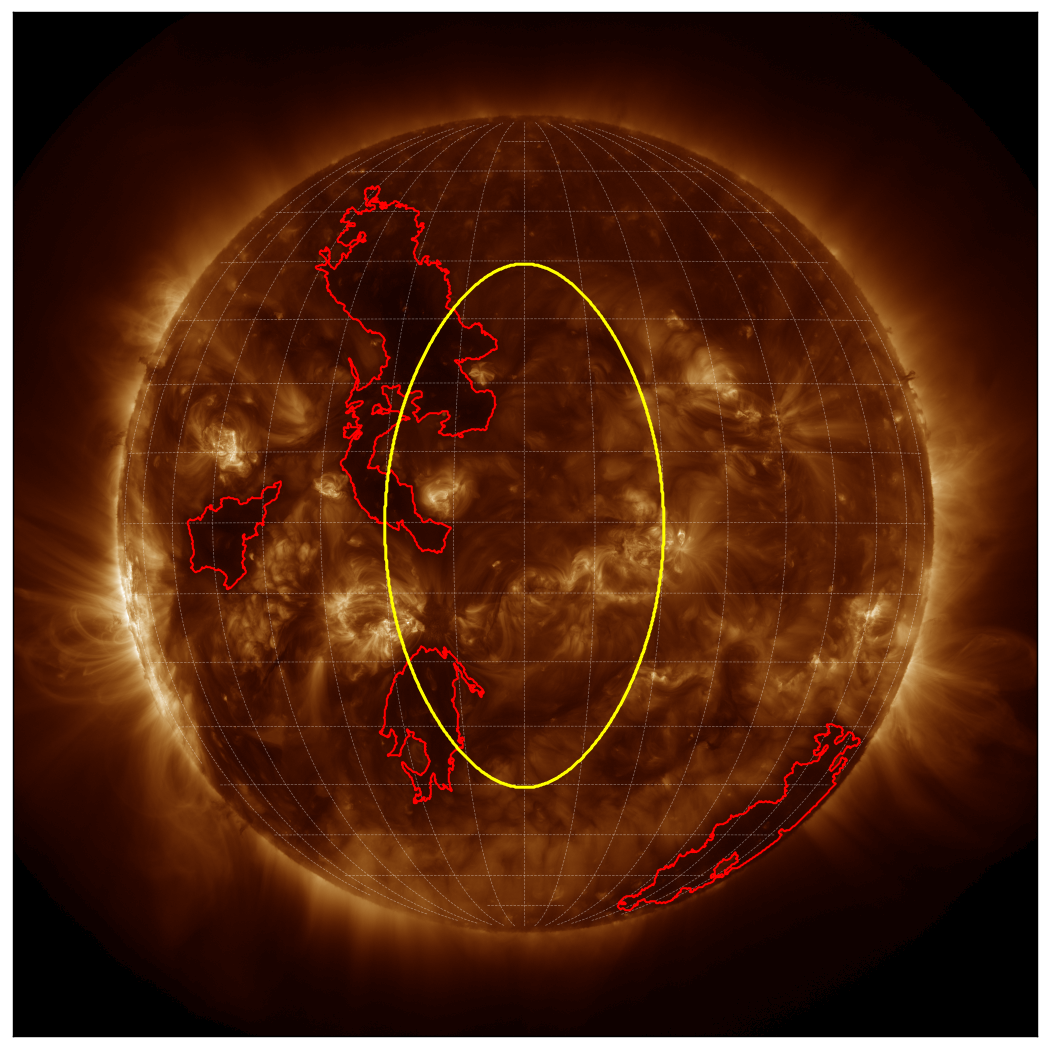

In [81]:
plot_ch_map(row, source="idl", postprocessing="P1")

In [82]:
map_aia = sunpy.map.Map(row.fits_path)
map_hmi = sunpy.map.Map(row.hmi_path)

INFO: Using mesh-based autoalignment [sunpy.map.mapbase]


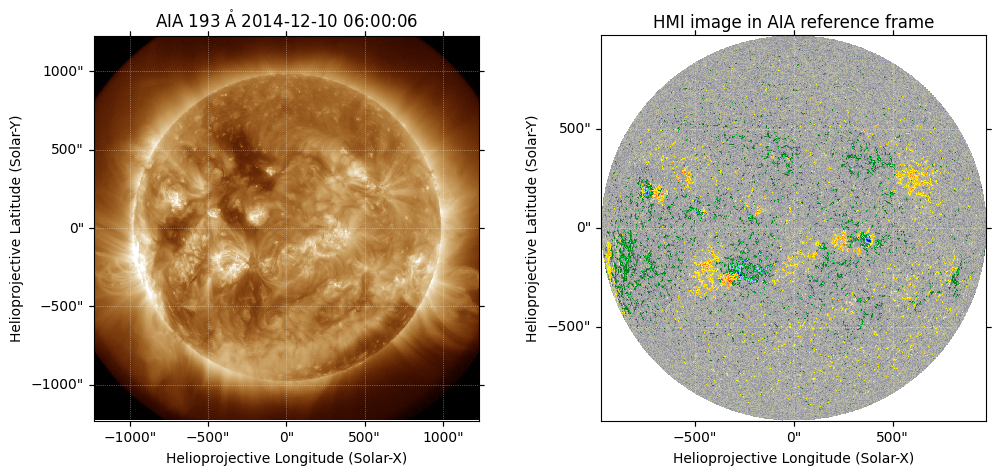

In [83]:
map_hmi.plot_settings["cmap"] = "hmimag"
map_hmi.plot_settings["norm"] = plt.Normalize(-1500, 1500)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection=map_aia)
map_aia.plot(axes=ax1, clip_interval=(1, 99.9) * u.percent)
ax2 = fig.add_subplot(122, projection=map_aia)
map_hmi.plot(axes=ax2, title="HMI image in AIA reference frame")


In [96]:
def plot_with_polarity(row, B_thresh=0.15, smoothing_params=None):
    """
    row: DataFrame row with row.fits_path and row.mask_path and row.hmi_path (FITS)
    B_thresh: threshold for HMI polarity field (in Gauss)
    smoothing_params: mask postprocessing parameters; defaults to P1 if None
    
    Creates 3x2 plot:
    - Row 1: AIA with polarity overlays (U-Net left, IDL right) - shows polarity within detected CH only
    - Row 2: HMI with CH contours (U-Net left, IDL right) - shows where CH is detected on magnetogram
    - Row 3: HMI with whole-disk polarity (U-Net left, IDL right) - shows magnetic field polarity everywhere
             • Red = positive polarity field (B >= B_thresh)
             • Blue = negative polarity field (B <= -B_thresh)
             • Black/gray = near-zero or weak field
             This reveals the underlying magnetic topology where coronal holes form.
    """
    
    if smoothing_params is None:
        smoothing_params = get_postprocessing_params("P1")

    _, aia = prepare_fits(row.fits_path)  # (1024×1024, normalized)
    
    # Load HMI magnetogram from FITS
    hmi_map = sunpy.map.Map(row.hmi_path)
    hmi_data = hmi_map.data.astype(np.float32)
    hmi = np.flipud(hmi_data)  # match orientation from prepare_fits
    
    # Resize to match AIA dimensions if needed
    if hmi.shape != aia.shape:
        hmi_pil = PIL.Image.fromarray(hmi)
        hmi_pil = hmi_pil.resize(aia.shape[::-1], resample=PIL.Image.BILINEAR)
        hmi = np.array(hmi_pil, dtype=np.float32)

    # Get U-Net mask from pmap
    pmap = find_or_make_pmap(row, model)
    nn_mask_raw = pmap_to_mask(pmap, smoothing_params)
    nn_mask = nn_mask_raw > 0.5

    # Get IDL mask
    idl_mask_raw = prepare_mask(row.mask_path)
    idl_mask = idl_mask_raw > 0.5

    # ====== For rows 1-2: polarity within detected coronal holes ======
    nn_pos = nn_mask & (hmi >= B_thresh)
    nn_neg = nn_mask & (hmi <= -B_thresh)

    idl_pos = idl_mask & (hmi >= B_thresh)
    idl_neg = idl_mask & (hmi <= -B_thresh)

    # ====== For row 3: whole-disk polarity (everywhere on disk) ======
    entire_pos = hmi >= B_thresh  # positive polarity anywhere on disk
    entire_neg = hmi <= -B_thresh  # negative polarity anywhere on disk

    # build RGBA overlays for polarity
    def make_overlay(pos, neg, alpha=0.5):
        h, w = pos.shape
        rgba_pos = np.zeros((h, w, 4), dtype=np.float32)
        rgba_neg = np.zeros((h, w, 4), dtype=np.float32)

        rgba_pos[..., 0] = 1.0  # red
        rgba_pos[..., 3] = alpha * pos.astype(float)

        rgba_neg[..., 2] = 1.0  # blue
        rgba_neg[..., 3] = alpha * neg.astype(float)

        return rgba_pos, rgba_neg

    nn_overlay_pos, nn_overlay_neg = make_overlay(nn_pos, nn_neg)
    idl_overlay_pos, idl_overlay_neg = make_overlay(idl_pos, idl_neg)
    
    entire_overlay_pos, entire_overlay_neg = make_overlay(entire_pos, entire_neg)

    # Normalize HMI for display
    hmi_norm = np.clip(hmi, -1000, 1000)
    hmi_norm = (hmi_norm + 1000) / 2000  # scale to [0, 1]

    # Create 3x2 subplot grid
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))

    # ==================== ROW 1: AIA with polarity ====================
    
    # [1,0]: U-Net on AIA
    ax = axes[0, 0]
    ax.imshow(aia, cmap=cmap)
    ax.contour(nn_mask.astype(float), levels=[0.5], colors="white", linewidths=1)
    ax.imshow(nn_overlay_pos)
    ax.imshow(nn_overlay_neg)
    ax.set_title("helio-n (U-Net) on AIA: red=+, blue=-")
    ax.axis("off")

    # [1,1]: IDL on AIA
    ax = axes[0, 1]
    ax.imshow(aia, cmap=cmap)
    ax.contour(idl_mask.astype(float), levels=[0.5], colors="white", linewidths=1)
    ax.imshow(idl_overlay_pos)
    ax.imshow(idl_overlay_neg)
    ax.set_title("IDL on AIA: red=+, blue=-")
    ax.axis("off")

    # ==================== ROW 2: HMI with CH contours ====================
    
    # [2,0]: U-Net contour on HMI
    ax = axes[1, 0]
    ax.imshow(hmi_norm, cmap='gray')
    ax.contour(nn_mask.astype(float), levels=[0.5], colors="yellow", linewidths=2)
    ax.set_title("helio-n (U-Net): CH contour on HMI")
    ax.axis("off")

    # [2,1]: IDL contour on HMI
    ax = axes[1, 1]
    ax.imshow(hmi_norm, cmap='gray')
    ax.contour(idl_mask.astype(float), levels=[0.5], colors="cyan", linewidths=2)
    ax.set_title("IDL: CH contour on HMI")
    ax.axis("off")

    # ==================== ROW 3: HMI with whole-disk polarity ====================
    
    # [3,0]: U-Net - whole disk polarity on HMI
    ax = axes[2, 0]
    ax.imshow(hmi_norm, cmap='gray')
    ax.contour(nn_mask.astype(float), levels=[0.5], colors="white", linewidths=1)
    ax.imshow(entire_overlay_pos)
    ax.imshow(entire_overlay_neg)
    ax.set_title("helio-n (U-Net): full-disk polarity (red=+, blue=-)")
    ax.axis("off")

    # [3,1]: IDL - whole disk polarity on HMI
    ax = axes[2, 1]
    ax.imshow(hmi_norm, cmap='gray')
    ax.contour(idl_mask.astype(float), levels=[0.5], colors="white", linewidths=1)
    ax.imshow(entire_overlay_pos)
    ax.imshow(entire_overlay_neg)
    ax.set_title("IDL: full-disk polarity (red=+, blue=-)")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Interactive plot with polarity threshold and row selection
# Prepare dataframe with date labels
df_with_date = df.dropna(subset=['hmi_path']).copy()
df_with_date['date'] = pd.to_datetime(df_with_date.index, format='%Y%m%d_%H%M').strftime('%Y-%m-%d %H:%M')

# Create sliders
b_thresh_slider = widgets.FloatSlider(
    value=0.15,
    min=-500.0,
    max=500.0,
    step=50.0,
    description="B Thresh:",
    continuous_update=False,
    layout=full_row,
)

polarity_idx_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=max(0, len(df_with_date) - 1),
    step=1,
    description="Row:",
    continuous_update=False,
    layout=full_row,
)

# Create output area
polarity_out = widgets.Output()

def update_polarity_plot(change=None):
    """Update the polarity plot when sliders change"""
    with polarity_out:
        clear_output(wait=True)
        
        if len(df_with_date) == 0:
            print("No valid data available")
            return
        
        row = df_with_date.iloc[polarity_idx_slider.value]
        b_thresh = b_thresh_slider.value
        date_str = row['date']
        
        print(f"Date: {date_str}")
        plot_with_polarity(row, B_thresh=b_thresh)

# Hook up callbacks
b_thresh_slider.observe(update_polarity_plot, names="value")
polarity_idx_slider.observe(update_polarity_plot, names="value")

# Display UI
polarity_controls = widgets.VBox([
    widgets.HBox([polarity_idx_slider], layout=full_row),
    widgets.HBox([b_thresh_slider], layout=full_row),
    polarity_out
], layout=full_row)

display(polarity_controls)

# Initial draw
update_polarity_plot(None)

Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,magnetogram
Wavelength,6173.0 Angstrom
Observation Date,2014-12-10 05:58:10
Exposure Time,Unknown
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[2.017431 2.017431] arcsec / pix
Reference Pixel,[511.416931 511.560364] pix

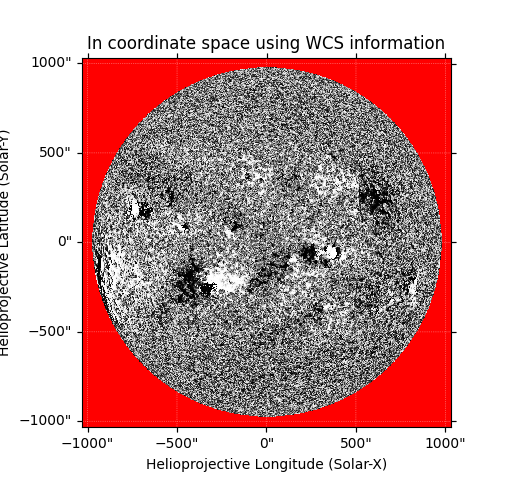
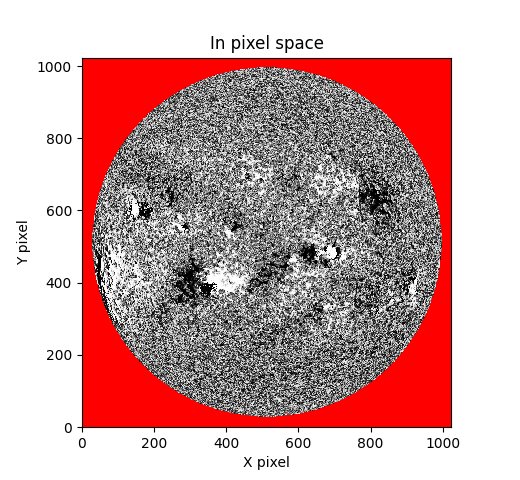
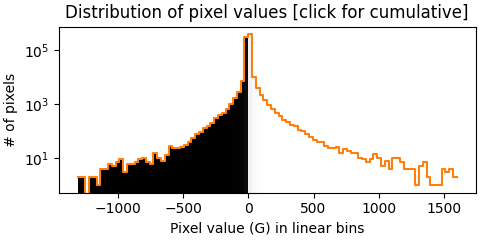
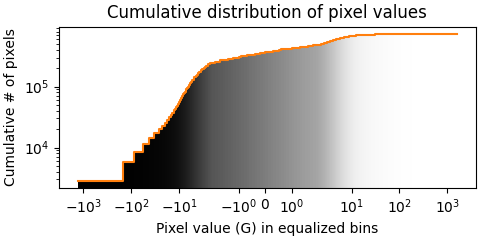

In [86]:
hmi = sunpy.map.Map(row.hmi_path)
hmi

In [87]:
import re
from pathlib import Path

hmi = "hmi.M_720s.20100513_000000_TAI.fits"
aia = "AIA20100513_000000_0193.fits"

print(re.search(r"(\\d{8}_\\d{6})", hmi).group(1))  # expect 20100513_000000
print(aia[3:16])  # current AIA key = 20100513_0000

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
train_df.sort_index()

In [ ]:
import pandas as pd
from Library.Config import paths
from Models import load_date_range

df = pd.read_parquet(paths["artifact_root"] + "Paths.parquet").sort_index()

arch_id = "A2"
date_id = "D1"
date_range = load_date_range(arch_id, date_id)

train_df, val_df = date_range.select_pairs(df)
print("train:", len(train_df), "val:", len(val_df))

# per-year counts (train)
for year in (2011, 2015, 2018, 2020):
    year_df = train_df.sort_index()[f"{year}0101_0000" :f"{year+1}0101_0000"]
    print(
        year, "rows:", len(year_df), "unique days:", year_df.index.normalize().nunique()
    )

# how keep_every would reduce it
kept = train_df.iloc[:: date_range.keep_every]
print("train kept:", len(kept), "keep_every:", date_range.keep_every)

# per-day counts (train)
per_day = train_df.groupby(train_df.index.normalize()).size()
print(
    "days:", len(per_day), "avg per day:", per_day.mean(), "max per day:", per_day.max()
)